In [1]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, f1_score

In [3]:
import seaborn as sns
df = sns.load_dataset('penguins')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
df.island.value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

In [6]:
target = 'species'
y = df[target]
x = df.drop(target, axis=1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

###### Get numerical and categorical features

In [8]:
numeric_features = x_train.select_dtypes(exclude=object).columns
numeric_features

Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')

In [9]:
categorical_features = x_train.select_dtypes(include=object).columns
categorical_features

Index(['island', 'sex'], dtype='object')

###### Specify transformers for each type of features

In [55]:
numeric_transformer = SimpleImputer()
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder()
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cate', categorical_transformer, categorical_features)   
    ]
)

# Create a pipeline with transformers and classifier
sklearn_clf = make_pipeline(preprocessor, DecisionTreeClassifier())

In [11]:
# Train the model
sklearn_clf.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')),
                                                 ('cate',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [12]:
# Get prediction
y_pred = sklearn_clf.predict(x_test)

In [13]:
f1_score(y_test, y_pred, average='micro')

0.9767441860465116

In [14]:
confusion_matrix(y_test, y_pred)

array([[40,  1,  1],
       [ 0, 14,  0],
       [ 0,  0, 30]], dtype=int64)

## Online learning

In [15]:
from river import (
    stream,
    compose,
    preprocessing,
    evaluate,
    metrics,
    tree,
    imblearn,
    stats
)
import numbers

In [16]:
for xi, yi in stream.iter_pandas(x, y):
    pass

In [19]:
x_sample = [{'age': 10}, {'age': 30}, {'age': None}, {'age': 2}, {'age': None}]
mean = stats.Mean()
imputer = preprocessing.StatImputer(('age', mean))
for xi_sample in x_sample:
    imputer.learn_one(xi_sample)
    print(imputer.transform_one(xi_sample))

{'age': 10}
{'age': 30}
{'age': 20.0}
{'age': 2}
{'age': 14.0}


In [22]:
def get_pipeline():
    # Specify the transfomers
    cate = (
        compose.SelectType(object)
        | preprocessing.StatImputer()
        | preprocessing.OneHotEncoder(sparse=True)
    )

    # Specify classifiers
    num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()
    preprocessing__ = num + cate

    classifier = tree.HoeffdingTreeClassifier()

    return preprocessing__ | classifier

In [23]:
pipeline = get_pipeline()
pipeline

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        <class 'numbers.Number'>
      ),
      StatImputer (
        imputers=()
      )
    ),
    Pipeline (
      Select (
        <class 'object'>
      ),
      StatImputer (
        imputers=()
      ),
      OneHotEncoder (
        sparse=True
      )
    )
  ),
  HoeffdingTreeClassifier (
    grace_period=200
    max_depth=inf
    split_criterion="info_gain"
    delta=1e-07
    tau=0.05
    leaf_prediction="nba"
    nb_threshold=0
    nominal_attributes=None
    splitter=GaussianSplitter (
      n_splits=10
    )
    binary_split=False
    max_size=100.
    memory_estimate_period=1000000
    stop_mem_management=False
    remove_poor_attrs=False
    merit_preprune=True
  )
)

In [26]:
def train(x, y):
    pipeline = get_pipeline()

    # Initialize metrics
    f1_score = metrics.MicroF1()
    cm = metrics.ConfusionMatrix()
    f1_scores = []

    # Iterate over the dataset
    for xi, yi in stream.iter_pandas(x, y, shuffle=True, seed=1):
        # Predict the new sample
        yi_pred = pipeline.predict_one(xi)
        # Get the score
        if yi_pred is not None:
            f1_score.update(yi, yi_pred)
            f1_scores.append(f1_score.get() * 100)
            cm.update(yi, yi_pred)
            
        # Train the model with the new sample
        pipeline.learn_one(xi, yi)

    return f1_scores, cm, pipeline

In [27]:
f1_scores, cm, pipeline = train(x, y)

In [28]:
pipeline.steps['HoeffdingTreeClassifier'].summary

{'n_nodes': 1,
 'n_branches': 0,
 'n_leaves': 1,
 'n_active_leaves': 1,
 'n_inactive_leaves': 0,
 'height': 1,
 'total_observed_weight': 344.0}

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

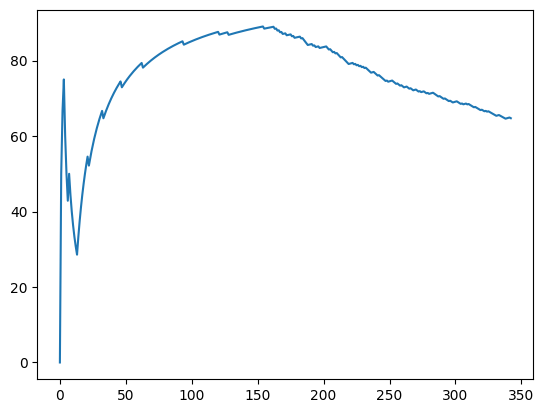

In [29]:
import matplotlib.pyplot as plt

def plot(scores: list):
    iters = range(len(scores))
    ax = sns.lineplot(x=iters, y=scores)
    ax.set(xlabel='Num_inters', ylabel='Score')
    plt.show()

plot(f1_scores)

In [53]:
evaluate.progressive_val_score(
    dataset=stream.iter_pandas(x, y, shuffle=True, seed=1),
    model=get_pipeline(),
    metric=metrics.MicroF1(),
    print_every=50, # print every 50 iterations
)

[50] MicroF1: 73.47%
[100] MicroF1: 84.85%
[150] MicroF1: 88.59%
[200] MicroF1: 83.42%
[250] MicroF1: 74.70%
[300] MicroF1: 68.90%


MicroF1: 64.72%

In [34]:
cm

            Adelie   Chinstrap   Gentoo  
   Adelie      143           8        0  
Chinstrap       44          22        2  
   Gentoo       66           1       57  

In [35]:
y.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [42]:
def get_pipeline_imbl():
    # Specify the transfomers
    cate = (
        compose.SelectType(object)
        | preprocessing.StatImputer()
        | preprocessing.OneHotEncoder(sparse=True)
    )

    num = compose.SelectType(numbers.Number) | preprocessing.StatImputer()
    preprocessing__ = num + cate
    
    # Specify classifiers
    classifier = tree.HoeffdingTreeClassifier()
    sampler = imblearn.RandomSampler(
        classifier = classifier,
        desired_dist = {'Adelie':0.1, 'Gentoo':0.4, 'Chinstrap':0.5},
        seed = 2
    )

    return preprocessing__ | sampler

In [43]:
def train_imbl(x, y):
    pipeline = get_pipeline_imbl()

    f1_score = metrics.MicroF1()
    cm = metrics.ConfusionMatrix()
    f1_scores = []

    for xi, yi in stream.iter_pandas(x, y, shuffle=True, seed=1):
        yi_pred = pipeline.predict_one(xi)

        if yi_pred is not None:
            f1_score.update(yi, yi_pred)
            f1_scores.append(f1_score.get() * 100)
            cm.update(yi, yi_pred)

        pipeline.learn_one(xi, yi)

    return f1_scores, cm, pipeline

In [44]:
f1_scores, cm, pipeline = train_imbl(x, y)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

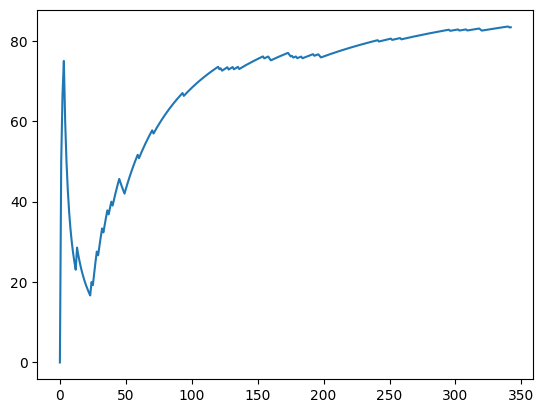

In [45]:
plot(f1_scores)

In [46]:
cm

            Adelie   Chinstrap   Gentoo  
   Adelie      111          37        3  
Chinstrap        5          62        1  
   Gentoo        5           6      113  

In [54]:
evaluate.progressive_val_score(
    dataset=stream.iter_pandas(x, y, shuffle=True, seed=1),
    model=get_pipeline_imbl(),
    metric=metrics.MicroF1(),
    print_every=50,
)

[50] MicroF1: 42.86%
[100] MicroF1: 67.68%
[150] MicroF1: 75.17%
[200] MicroF1: 75.88%
[250] MicroF1: 80.32%
[300] MicroF1: 82.61%


MicroF1: 83.38%